<img src="./fiuba.jpg" align="right" width="150" /> 
#### Procesamiento Digital de Señales

# Trabajo Práctico 1
#### Ericson Estupiñan

***
## Procesos aleatorios

### PARTE 1

<div class="alert alert-block alert-info">
<b>a)</b> Filtrar la señal con un filtro digital para eliminar potencia de ruido. Pueden probar
con filtros FIR o IIR, los que les parezcan convenientes.
    
¿Es óptimo el filtro elegido para detectar la información en forma confiable?

</div>

In [38]:
import numpy as np

tpsignalLowSNR = np.load('signalLowSNR.npy')
tpsignal = np.load('signal.npy')
tppulse  = np.load('pulse.npy')

print('Signal and data information')

print("Signal size: {} samples".format(len(tpsignal)))
numBits = len(tpsignal)/20
print("Data size:   {} bits , {} Bytes".format(numBits, (len(tpsignal)/20)/8))
print("Pulse size:  {}".format(len(tppulse)))

Signal and data information
Signal size: 32560 samples
Data size:   1628.0 bits , 203.5 Bytes
Pulse size:  20


Text(0.5, 1.0, 'Pulso de modulación')

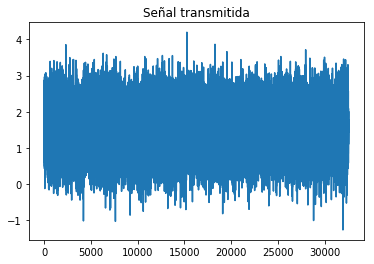

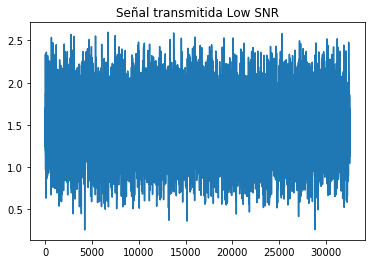

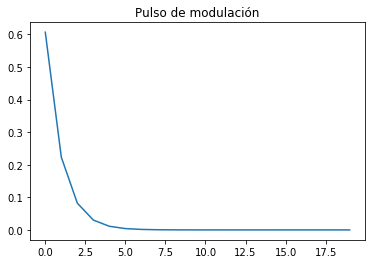

In [39]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(tpsignal)
plt.title('Señal transmitida')

plt.figure()
plt.plot(tpsignalLowSNR)
plt.title('Señal transmitida Low SNR')

plt.figure()
plt.plot(tppulse)
plt.title('Pulso de modulación')

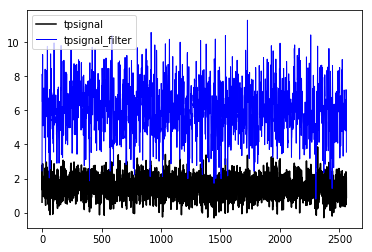

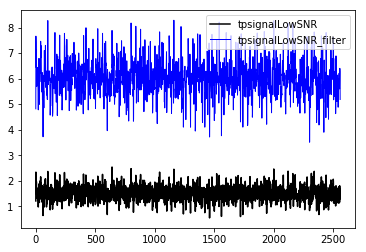

In [40]:
from scipy import signal
from scipy.fftpack import fft

# Variables
NBYTES = 16             # Numero de bytes
NSAMPLE = 160 * NBYTES # Numero de samples a demodular

# Filtro FIR
a = [1,1,0]
b = np.zeros(len(a))
b[0] = 1
tpsignal_filter = signal.filtfilt(a,b,tpsignal[0:NSAMPLE])

plt.figure()
plt.plot(tpsignal[:NSAMPLE], 'k-', label='tpsignal')
plt.plot(tpsignal_filter[:NSAMPLE], 'b-', linewidth=1, label='tpsignal_filter')
plt.legend(loc='best')


tpsignalLSNR_filter = signal.filtfilt(a,b,tpsignalLowSNR[0:NSAMPLE])

plt.figure()
plt.plot(tpsignalLowSNR[:NSAMPLE], 'k-', label='tpsignalLowSNR')
plt.plot(tpsignalLSNR_filter[:NSAMPLE], 'b-', linewidth=1, label='tpsignalLowSNR_filter')
plt.legend(loc='best')


<div class="alert alert-block alert-warning">
<b>Respuesta:</b> NO, aunque ayuda a filtrar altas frecuencias adicionadas por ruido. Se realizarón pruebas con otros filtros pasabajos pero sin tener buenos resultados.
</div>

<div class="alert alert-block alert-info">
<b>b)</b>  Definir un umbral que permita tomar decisiones ("vino un 1" o "vino un 0") para
cada pulso y reconstruir la trama enviada. Nuevamente, ¿Es óptimo ese umbral?

</div>

In [41]:
sig_mean = np.mean(tpsignal_filter)
print("Mean filter signal: {}".format(sig_mean))

sig_meanLSNR = np.mean(tpsignalLSNR_filter)
print("Mean filter signal: {}".format(sig_meanLSNR))

Mean filter signal: 6.086148754486432
Mean filter signal: 6.028558300810518


<div class="alert alert-block alert-warning">
<b>Respuesta:</b> Se definio como umbral de dicision la media de la señal.
</div>

### Signal FIR Filter

In [42]:
import bitstring as bs

numBits = int(NSAMPLE/20) 
bitstream = []
bytestream = []
byteCount = 0
bites = []

print('Se revisan los primeros 16 Bytes correspondientes a el header')
print('su valor debe ser igual a 0b10101100')
print('')

for i in range(numBits):
    sample =  tpsignal_filter[(i*20) + 1]
    byteCount += 1
    if (sample > sig_mean):
        bitstream.append(1)
        bites.append(1)
    else:
        bitstream.append(0)
        bites.append(0)
        
    if(byteCount == 8):
        bytestream.append(np.array(bites))
        bites = []
        byteCount = 0
        
sByteHeader = "10101100"
totalBitsError = 0;

for data in bytestream:    
    byte = bs.BitArray(data)
    sByteBin = str(byte.bin)
    errBits = 0;
    for i in range(len(sByteHeader) - 1):
        if sByteHeader[i] != sByteBin[i]:
            errBits += 1
    totalBitsError += errBits
    print("0x{} 0b{}, {}".format(str(byte.hex),str(byte.bin), errBits))

bitsTotal = numBits
print("Num bits: {} Num bits error: {}, Error: {}%".format(bitsTotal, totalBitsError, (totalBitsError/bitsTotal)*100))

Se revisan los primeros 16 Bytes correspondientes a el header
su valor debe ser igual a 0b10101100

0xac 0b10101100, 0
0xad 0b10101101, 0
0xad 0b10101101, 0
0xfd 0b11111101, 2
0xec 0b11101100, 1
0xbf 0b10111111, 2
0x2e 0b00101110, 2
0xb4 0b10110100, 2
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xae 0b10101110, 1
0xac 0b10101100, 0
0x2c 0b00101100, 1
0xad 0b10101101, 0
Num bits: 128 Num bits error: 11, Error: 8.59375%


<div class="alert alert-block alert-warning">
<b>Respuesta:</b> NO, pero se logra demodular varios de los datos del header de forma correcta.
</div>

### Signal Low SNR FIR Filter

In [43]:
numBits = int(NSAMPLE/20) 
bitstream = []
bytestream = []
byteCount = 0
bites = []

print('Se revisan los primeros 16 Bytes correspondientes a el header')
print('su valor debe ser igual a 0b10101100')
print('')

for i in range(numBits):
    sample =  tpsignalLSNR_filter[(i*20) + 1]
    byteCount += 1
    if (sample > sig_meanLSNR):
        bitstream.append(1)
        bites.append(1)
    else:
        bitstream.append(0)
        bites.append(0)
        
    if(byteCount == 8):
        bytestream.append(np.array(bites))
        bites = []
        byteCount = 0

        
sByteHeader = "10101100"
totalBitsError = 0;

for data in bytestream:    
    byte = bs.BitArray(data)
    sByteBin = str(byte.bin)
    errBits = 0;
    for i in range(len(sByteHeader) - 1):
        if sByteHeader[i] != sByteBin[i]:
            errBits += 1
    totalBitsError += errBits
    print("0x{} 0b{}, {}".format(str(byte.hex),str(byte.bin), errBits))

bitsTotal = numBits
print("Num bits: {} Num bits error: {}, Error: {}%".format(bitsTotal, totalBitsError, (totalBitsError/bitsTotal)*100))

Se revisan los primeros 16 Bytes correspondientes a el header
su valor debe ser igual a 0b10101100

0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
Num bits: 128 Num bits error: 0, Error: 0.0%


<div class="alert alert-block alert-warning">
<b>Respuesta:</b> Para un señal de menor SNR el umbral de valor medio es muy preciso, demodulando los 16 bytes del header.
</div>

## PARTE 2

<div class="alert alert-block alert-info">
Repetir el procedimiento para la parte 1, pero utilizar el filtro y el umbral óptimo.
</div>

### Signal Adaptive Filter

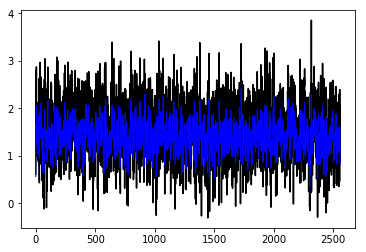

In [44]:
signal_AFilter = signal.filtfilt(np.flip(tppulse),1,tpsignal[0:NSAMPLE])

plt.figure()
plt.plot(tpsignal[:NSAMPLE], 'k-', label='tpsignal')
plt.plot(signal_AFilter[:NSAMPLE], 'b-', linewidth=1, label='signal_AFilter')

### Signal Low SNR Adaptive Filter

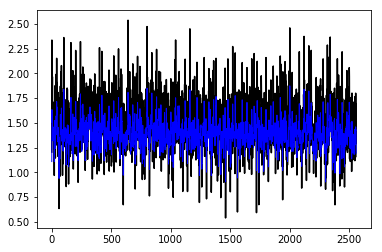

In [45]:
signalLSNR_AFilter = signal.filtfilt(np.flip(tppulse),1,tpsignalLowSNR[0:NSAMPLE])

plt.figure()
plt.plot(tpsignalLowSNR[:NSAMPLE], 'k-', label='tpsignalLowSNR')
plt.plot(signalLSNR_AFilter[:NSAMPLE], 'b-', linewidth=1, label='signalLSNR_AFilter')

### Signal Adaptive Filter Histogram

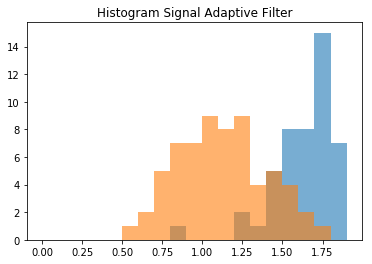

[ 0  0  0  0  0  0  0  0  1  0  0  0  2  1  5  8  8 15  7]
[0 0 0 0 0 1 2 5 7 7 9 8 9 4 5 4 2 1 0]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9]


In [46]:
byteHeader = [1, 0, 1, 0, 1, 1, 0, 0]
onesList  = []
zerosList = []
byteCount = 0

for i in range(numBits):
    sample =  signal_AFilter[(i*20) + 1]
    if(byteHeader[byteCount] == 1):
        onesList.append(sample)
    else:
        zerosList.append(sample)
    byteCount += 1
    if(byteCount == 8):
        byteCount = 0
          
plt.figure()
histRange =  np.arange(0, 2, 0.1) 
plt.hist(onesList, bins=histRange, alpha=0.6, label='1 bits')
plt.hist(zerosList, bins=histRange, alpha=0.6, label='0 bits')
plt.title("Histogram Signal Adaptive Filter")
plt.show()

onesHist, bins = np.histogram(onesList, bins=histRange)
zerosHist, bins = np.histogram(zerosList, bins=histRange)
print(onesHist)
print(zerosHist)
print(bins)

<div class="alert alert-block alert-warning">
<b>Respuesta:</b> De acuerdo al histograma se puede ver que para valores entre 1.4 y 1.5 no es posible diferenciar si un bit es 1 o 0. Pero para muestras menores a 1.4 es mayor la probabilidad de que sea 0 y para valores mayores a 1.5 la pababilidad de que sea 1 es mayor.
</div>

In [47]:
bitstream = []
bytestream = []
byteCount = 0
bites = []
for i in range(numBits):
    sample =  signal_AFilter[(i*20) + 1]
    
    if (sample > 1.6):
        bitstream.append(1)
        bites.append(1)
    elif(sample < 1.4):
        bitstream.append(0)
        bites.append(0)
    else:
        ## QUE DECISION TOMAR?
        ## Probabilidad de la posicion del bit
        if(byteHeader[byteCount] == 1):
            bitstream.append(1)
            bites.append(1)
        else:
            bitstream.append(0)
            bites.append(0)
       
    byteCount += 1
    if(byteCount == 8):
        bytestream.append(np.array(bites))
        bites = []
        byteCount = 0
        
sByteHeader = "10101100"
totalBitsError = 0;    
    
for data in bytestream:    
    byte = bs.BitArray(data)
    sByteBin = str(byte.bin)
    errBits = 0;
    for i in range(len(sByteHeader) - 1):
        if sByteHeader[i] != sByteBin[i]:
            errBits += 1
    totalBitsError += errBits
    print("0x{} 0b{}, {}".format(str(byte.hex),str(byte.bin), errBits))

bitsTotal = numBits
print("----------------------------------------")
print("Num bits: {} Num bits error: {}, Error: {}%".format(bitsTotal, totalBitsError, (totalBitsError/bitsTotal)*100))
print("----------------------------------------")

0xac 0b10101100, 0
0xad 0b10101101, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xad 0b10101101, 0
0x2c 0b00101100, 1
0xb4 0b10110100, 2
0xac 0b10101100, 0
0x2c 0b00101100, 1
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0x2c 0b00101100, 1
0xac 0b10101100, 0
----------------------------------------
Num bits: 128 Num bits error: 5, Error: 3.90625%
----------------------------------------


### Signal Low SNR Filter Histogram

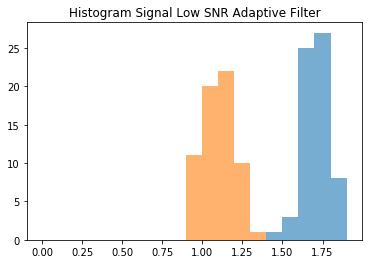

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  3 25 27  8]
[ 0  0  0  0  0  0  0  0  0 11 20 22 10  1  0  0  0  0  0]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9]


In [48]:
# Make Histogram
    
byteHeader = [1, 0, 1, 0, 1, 1, 0, 0]
onesList  = []
zerosList = []
byteCount = 0

for i in range(numBits):
    sample =  signalLSNR_AFilter[(i*20) + 1]
    if(byteHeader[byteCount] == 1):
        onesList.append(sample)
    else:
        zerosList.append(sample)
    byteCount += 1
    if(byteCount == 8):
        byteCount = 0
        
plt.figure()
histRange =  np.arange(0, 2, 0.1) 
plt.hist(onesList, bins=histRange, alpha=0.6, label='my label')
plt.hist(zerosList, bins=histRange, alpha=0.6, label='0 bits')
plt.title("Histogram Signal Low SNR Adaptive Filter")
plt.show()

onesHist, bins = np.histogram(onesList, bins=histRange)
zerosHist, bins = np.histogram(zerosList, bins=histRange)
print(onesHist)
print(zerosHist)
print(bins)


<div class="alert alert-block alert-warning">
<b>Respuesta:</b> En este caso después del histograma se puede diferenciar claramente el umbral de decisión que es 1.4
</div>

In [49]:
bitstream = []
bytestream = []
byteCount = 0
bites = []
umbral = 1.4 # Umbral

for i in range(numBits):
    sample =  signalLSNR_AFilter[(i*20) + 1]
    byteCount += 1
    if (sample > umbral):
        bitstream.append(1)
        bites.append(1)
    else:
        bitstream.append(0)
        bites.append(0)
        
    if(byteCount == 8):
        bytestream.append(np.array(bites))
        bites = []
        byteCount = 0
        
        
sByteHeader = "10101100"
totalBitsError = 0;

for data in bytestream:    
    byte = bs.BitArray(data)
    sByteBin = str(byte.bin)
    errBits = 0;
    for i in range(len(sByteHeader) - 1):
        if sByteHeader[i] != sByteBin[i]:
            errBits += 1
    totalBitsError += errBits
    print("0x{} 0b{}, {}".format(str(byte.hex),str(byte.bin), errBits))

bitsTotal = numBits
print("----------------------------------------")
print("Num bits: {} Num bits error: {}, Error: {}%".format(bitsTotal, totalBitsError, (totalBitsError/bitsTotal)*100))
print("----------------------------------------")

0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
0xac 0b10101100, 0
----------------------------------------
Num bits: 128 Num bits error: 0, Error: 0.0%
----------------------------------------
